## Fectching Data from Google Drive

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive', force_remount=False)

# Define dataset path
dataset_path = "/content/drive/My Drive/Animals"

# Ensure the dataset path exists
if os.path.exists(dataset_path):
    print(f"✅ Dataset path found: {dataset_path}")

    # List files inside the dataset folder
    files = os.listdir(dataset_path)
    print(f"📂 Files in dataset folder: {files[:10]}")  # Display only first 10 files for brevity
else:
    print("❌ Dataset path not found! Check if the folder name and path are correct.")


Mounted at /content/drive
✅ Dataset path found: /content/drive/My Drive/Animals
📂 Files in dataset folder: ['horse', 'lion', 'dog', 'elephant', 'cat']


In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


## Loading Data

In [ ]:
dataset_path = "/content/drive/My Drive/Animals"  # Update this path

files = [] # Empty list for the subfolders like lion, elephant , dog ,cat , horse store there audio files
labels = [] # Empty list for the labels like name lion , elephant and all
for animal in os.listdir(dataset_path): # Loops through all the entries (files and folders) in the main dataset folder.
# animal will hold each subfolder name one at a time (which are animal names like "dog", "cat", etc.).
    animal_path = os.path.join(dataset_path, animal) # Creates the full path to that specific animal folder like path for lion in Animals etc..
    if os.path.isdir(animal_path): # Checks the current path is a folder if not then not use them due to they are stray files that might be in the root dataset folder.
        for file in os.listdir(animal_path): # Loops through all the files inside the animal's folder (hopefully .wav files).
            if file.endswith(".wav"):
                files.append(os.path.join(animal_path, file)) # Adds the full path of the .wav file to the files list.
                labels.append(animal) # Adds the label (i.e., the animal name) to the labels list

print(f"Total audio samples: {len(files)}")
print(f"Animal categories: {set(labels)}")


Total audio samples: 3430
Animal categories: {'dog', 'elephant', 'cat', 'horse', 'lion'}


## Data Preprocessing
1) Loading

2) Resampling

3) Mfcc features extraction

4) Scaling/ Normalization

In [ ]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler

# file_path: where the audio file is.

# max_pad_length: make all MFCCs the same length (100 frames).

# target_sr: target sample rate = 16,000 samples/sec.

# n_mfcc: number of MFCC features to extract (40).

# min_duration: make sure the audio is at least 0.5 seconds

def extract_features(file_path, max_pad_length=100, target_sr=16000, n_mfcc=40, min_duration=0.5): # This function processes one audio file and returns its MFCC features
    # Load and resample audio
    y, sr = librosa.load(file_path, sr=target_sr) # y is the audio signal (a NumPy array) and sr is the sampling rate (set to 16000 Hz).
    # sr = None mean originial sampling rate
    # Librosa load made audio in numpy array
    # This gives 1D array with elements number is calculated as duration (in seconds) × sampling rate (in Hz)

    # Ensure minimum duration
    min_samples = int(min_duration * sr)
    if len(y) < min_samples:
        y = np.pad(y, (0, min_samples - len(y)), mode='constant')

    # If the audio is shorter than 0.5 seconds, it pads zeros at the end to reach the minimum length.
    # This avoids errors later on due to inconsistent lengths.
    # mode='constant' tells NumPy to pad with a constant value (default is 0).

    # Extract MFCC with smaller n_fft to avoid warnings
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=256)

    # n_mfcc: Number of MFCCs per frame (usually 13, but can be more).
    # t: Number of time frames, depending on the length of the audio, n_fft, and hop_length.
    # The mfcc is a 2d array


    # y=y: This is the audio time series, which should be a 1D NumPy array. It represents the raw waveform of your audio.
    # sr=sr: The sampling rate of the audio signal (e.g., 22050 Hz)

    # n_fft = The number of samples per frame in the Short-Time Fourier Transform (STFT). default 2048
    # n_mfcc
    # What it is: The number of MFCC coefficients to extract.
    # Default: 20
    # What it affects: Higher values give more detailed frequency info, but may add noise.
    # Typical values: 13 (common in speech), 20–40 (for emotions/music tasks)
    # hop_length
    # How far you move forward on the audio signal each time you take a chunk (window) to analyze.

    # Pad or trim MFCC to fixed length
    if mfcc.shape[1] < max_pad_length: # 1 refers to the number of time steps / frames in the MFCC feature.
        pad_width = max_pad_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_pad_length]

    # MFCCs have shape: (40, number_of_frames)
    # This makes sure every audio file has exactly 100 time steps (frames), so the model can handle them.
    # If the MFCC is short, we pad it with zeros.
    # If it’s too long, we cut it to size.
    # 40 → Number of MFCC coefficients (you set this via n_mfcc=40)
    # number_of_frames → How many small time slices (frames) were extracted from the audio signal, based on n_fft and hop_length

    return mfcc.T  # Shape: (100, 40) # We transpose to get shape (100 frames, 40 features) — perfect for feeding into models like LSTMs.
    # # 40 coefficients × 100 time frames

# Example usage
X_raw = [extract_features(file) for file in files] # this procees all audio and made each audio a mfcc 2D matrix
X = np.array(X_raw) # Convert to numpy array from 2D to 3D where
# Let's say you have 500 audio files, each MFCC shape is (100, 40)
# X.shape == (500, 100, 40)

# Flatten for scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1))

print("✅ Feature extraction, resampling, and scaling completed without warnings.")


✅ Feature extraction, resampling, and scaling completed without warnings.


In [ ]:
# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Train K means Clustering for emotions Capturing

In [ ]:
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

# Step 0: Set random seeds globally to eliminate all randomness
np.random.seed(42)
random.seed(42)

# Step 1: Define number of emotion clusters
num_emotions = 5

# Step 2: Fix randomness in KMeans by setting random seed and limiting initialization
kmeans = KMeans(n_clusters=num_emotions, init='k-means++', n_init=1, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# init
# This controls how the initial centroids (starting points for the clusters) are selected.
# k-means++
# A smarter method. It spreads out initial centroids to be far from each other, reducing the chance of bad clustering and speeding up convergence.

# n_init
# ➡️ KMeans runs only once, starting from the centroids initialized using random_state=42.
# ➡️ This makes the output fully deterministic (no randomness at all).

# Step 3: Emotion label mapping (avoid arbitrary mapping!)
# Optional — use Hungarian algorithm if you have true labels:
# confusion = confusion_matrix(true_emotion_labels, clusters)
# row_ind, col_ind = linear_sum_assignment(-confusion)
# cluster_to_emotion_map = dict(zip(col_ind, row_ind))  # cluster -> emotion index

# fit_predict does two things:
# Fits the KMeans algorithm to the data
# Assigns each sample a cluster number from 0 to 4
# KMeans assigns cluster numbers randomly but we do mapping of each cluster with seperate emotion eliminate randomness

# Manual cluster to emotion mapping (after inspection or listening)
cluster_to_emotion = { # Mapping
    0: "happy",
    1: "sad",
    2: "fear",
    3: "angry",
    4: "neutral"
}

emotion_labels = ['happy','sad','fear','angry','neutral']

# Step 4: Convert clusters to emotions using the fixed mapping
y_emotions = np.array([cluster_to_emotion[c] for c in clusters]) # Make cluster Ids like in mapping to made in String format like emotions

# Step 5: Inspect outputs
print("Cluster IDs:", clusters[:10])
print("Mapped emotions:", y_emotions[:10])


Cluster IDs: [0 0 0 0 1 0 0 0 0 0]
Mapped emotions: ['happy' 'happy' 'happy' 'happy' 'sad' 'happy' 'happy' 'happy' 'happy'
 'happy']


In [ ]:
import joblib

# Save KMeans model directly in the current directory
kmeans_model_path = "kmeans_model.pkl"
joblib.dump(kmeans, kmeans_model_path)

print(f"✅ KMeans model saved at: {kmeans_model_path}")


✅ KMeans model saved at: kmeans_model.pkl


## Exploratory Data Analysis

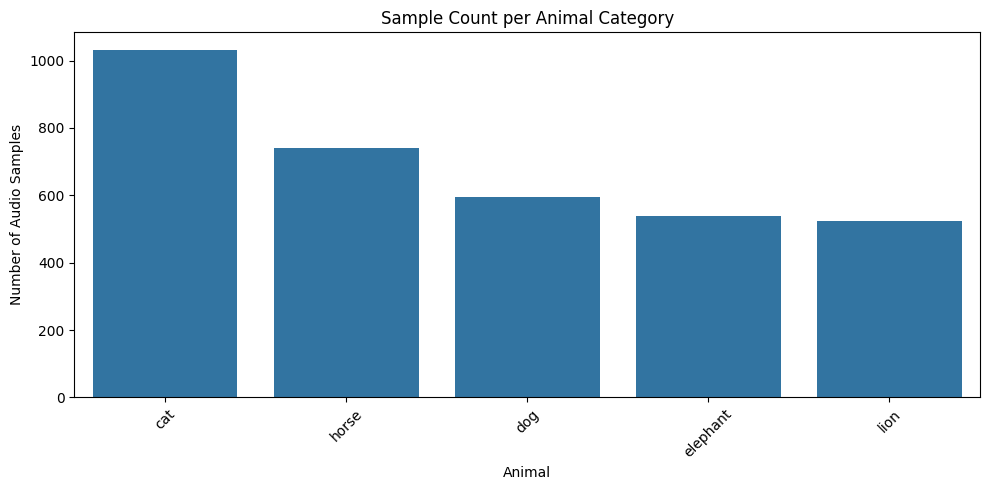

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe for easy visualization
df = pd.DataFrame({"file": files, "animal": labels})

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="animal", order=df['animal'].value_counts().index)
plt.title("Sample Count per Animal Category")
plt.xlabel("Animal")
plt.ylabel("Number of Audio Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


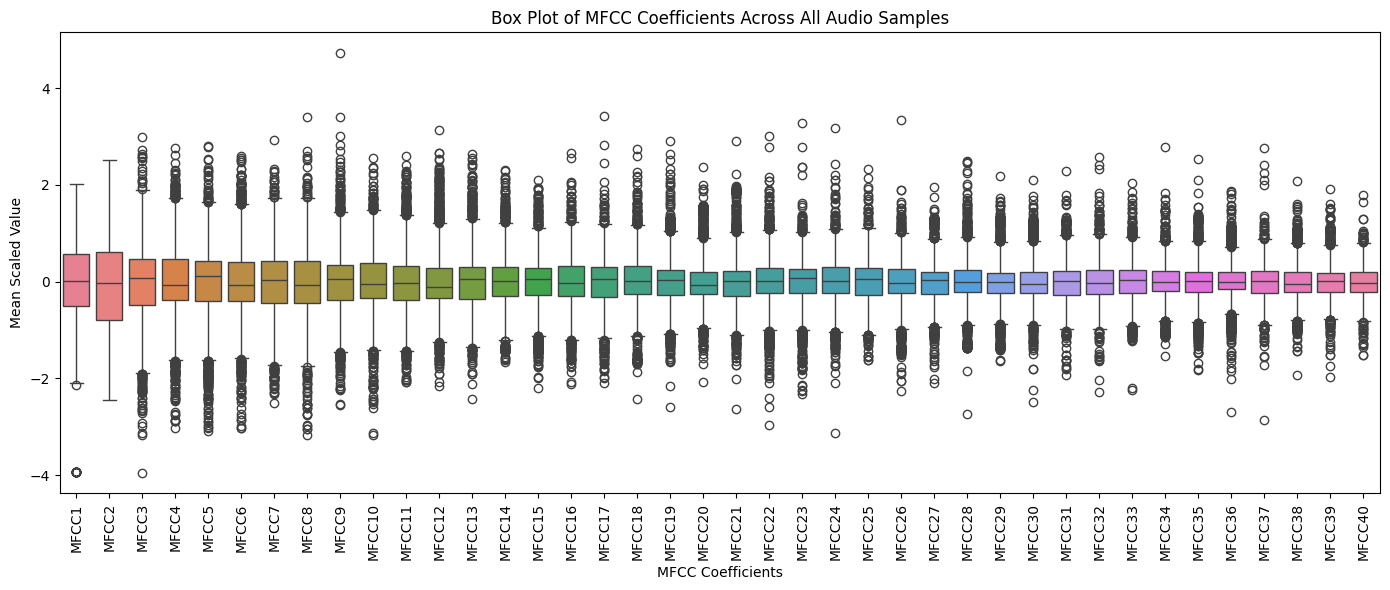

In [ ]:
# Convert scaled data back to (num_samples, 100, 40) for plotting
X_scaled_reshaped = X_scaled.reshape(X.shape[0], 100, 40)

# Take average over time axis for boxplot (shape: [num_samples, n_mfcc])
mfcc_means = X_scaled_reshaped.mean(axis=1)

plt.figure(figsize=(14, 6))
sns.boxplot(data=pd.DataFrame(mfcc_means, columns=[f"MFCC{i+1}" for i in range(40)]))
plt.title("Box Plot of MFCC Coefficients Across All Audio Samples")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Mean Scaled Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


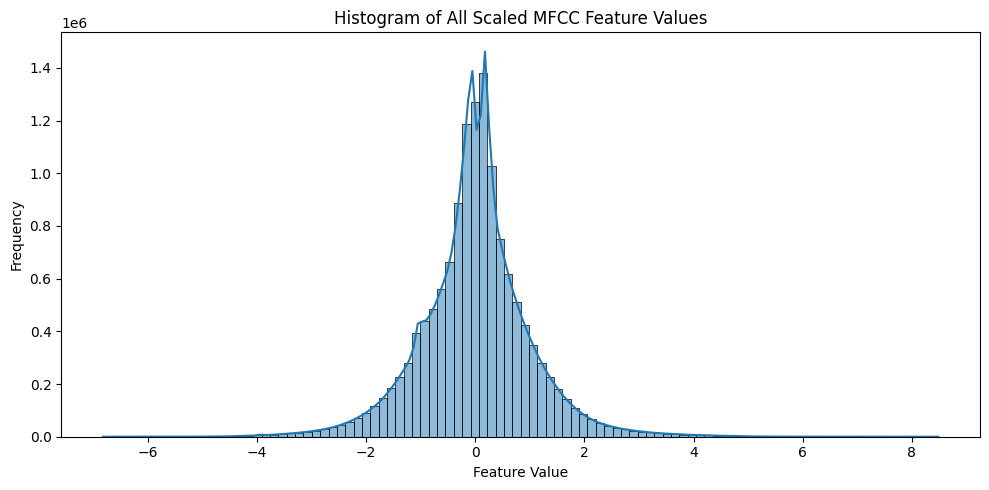

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(X_scaled.flatten(), bins=100, kde=True)
plt.title("Histogram of All Scaled MFCC Feature Values")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


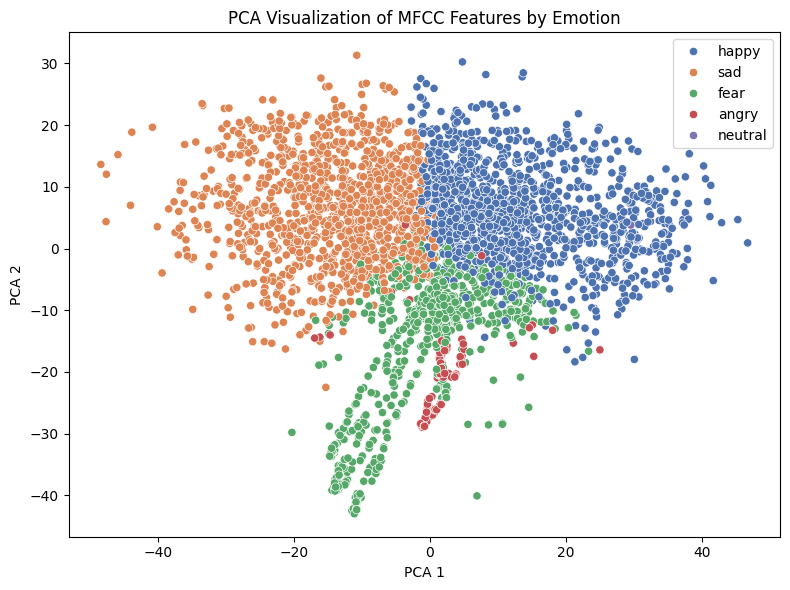

In [ ]:
from sklearn.decomposition import PCA

# Reduce MFCC feature dimensions
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_emotions, palette="deep")
plt.title("PCA Visualization of MFCC Features by Emotion")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
import numpy as np

# Count class occurrences
class_counts = Counter(clusters)

#  This creates a dictionary-like object showing how many data points are assigned to each cluster:

# Filter out classes with < 2 samples
valid_indices = [i for i, label in enumerate(clusters) if class_counts[label] >= 2]

# This builds a list of indices where the sample belongs to a "valid" cluster (with ≥ 2 members).
# This removes tiny clusters that may be unstable or irrelevant.

# Apply filtering
X_filtered = X[valid_indices]
clusters_filtered = np.array(clusters)[valid_indices]
X_flat_filtered = X_filtered.reshape(X_filtered.shape[0], -1)

# Now you’re only keeping samples from meaningful clusters.


## Train Test Split

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_flat_filtered, clusters_filtered):
    X_train_raw, X_test_raw = X_filtered[train_idx], X_filtered[test_idx]
    y_train_cluster, y_test_cluster = clusters_filtered[train_idx], clusters_filtered[test_idx]

# Stratified splitting setup:
# n_splits=1: Just one train-test split.
# test_size=0.2: 20% of the data goes to test set.
# random_state=42: Ensures reproducibility (same split every run).
# ✅ Stratified means that each cluster/emotion has the same proportion in train/test sets.

# sss.split(X_flat_filtered, clusters_filtered) splits the data, preserving label distribution from clusters_filtered.
# You then extract:
# X_train_raw: audio samples for training
# X_test_raw: audio samples for testing
# y_train_cluster: corresponding cluster labels for training
# y_test_cluster: cluster labels for testing

# KNN baselineknn = KNeighborsClassifier(n_neighbors=5)
# Reshape from (samples, time_steps, features) -> (samples, features_flattened)
X_train_reshaped = X_train_raw.reshape(len(X_train_raw), -1)
X_test_reshaped = X_test_raw.reshape(len(X_test_raw), -1)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_reshaped, y_train_cluster)

# Evaluate KNN
acc = knn.score(X_test_reshaped, y_test_cluster)
print(f"KNN Accuracy: {acc:.2f}")

print(f"🧪 Baseline KNN Accuracy (Stratified, Filtered): {acc:.2f}")


KNN Accuracy: 0.82
🧪 Baseline KNN Accuracy (Stratified, Filtered): 0.82


In [ ]:
import joblib

# Save KMeans model directly in the current directory
knn_model_path = "knn_model.pkl"
joblib.dump(knn, knn_model_path)

print(f"✅ KMeans model saved at: {knn_model_path}")


✅ KMeans model saved at: knn_model.pkl


## Model Building and Training

In [ ]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.utils import to_categorical

# One-hot encode emotion cluster labels
y_train_cat = to_categorical(y_train_cluster, num_classes=num_emotions) # Convert the seperate emotions to seperate array
y_test_cat = to_categorical(y_test_cluster, num_classes=num_emotions)

# y_train_cat = [
#   [1, 0, 0],  # class 0 → happy
#   [0, 0, 1],  # class 2 → angry
#   [0, 1, 0],  # class 1 → sad
#   [0, 0, 1]   # class 2 → angry
# ]

# Define model using Input layer
model = Sequential([
    Input(shape=(100, 40)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(num_emotions, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(
    X_train_raw, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_raw, y_test_cat)
)

# Save
model.save("emotion_classifier.keras")
print("✅ LSTM model trained and saved.")


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6180 - loss: 0.9479 - val_accuracy: 0.8950 - val_loss: 0.3366
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8371 - loss: 0.4601 - val_accuracy: 0.9009 - val_loss: 0.2698
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9160 - loss: 0.2606 - val_accuracy: 0.9169 - val_loss: 0.2589
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9001 - loss: 0.2786 - val_accuracy: 0.9373 - val_loss: 0.1936
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9480 - loss: 0.1625 - val_accuracy: 0.9169 - val_loss: 0.2196
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9296 - loss: 0.1855 - val_accuracy: 0.9431 - val_loss: 0.1646
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9419 - loss: 0.1652 - val_accuracy: 0.9388 - val_loss: 0.1654
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9507 - loss: 0.1376 - val_accuracy: 0.9490 - v

## Evaluation of model on test data

In [ ]:
def predict_with_confidence(model, sample, threshold=0.9):
    sample = np.expand_dims(sample, axis=0)  # Add batch dimension
    probs = model.predict(sample)[0]
    max_prob = np.max(probs)
    predicted_index = np.argmax(probs)

    if max_prob < threshold:
        return "Unknown", max_prob
    else:
        return emotion_labels[predicted_index], max_prob

# Test prediction
sample = X_test_raw[0]
emotion, confidence = predict_with_confidence(model, sample)

print(f"Predicted Emotion: {emotion} (Confidence: {confidence:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Predicted Emotion: sad (Confidence: 1.00)


In [ ]:
# Evaluate model performance
loss, accuracy = model.evaluate(X_test_raw, y_test_cat, verbose=1)
print(f"✅ Test Accuracy: {accuracy:.2f}")
print(f"📉 Test Loss: {loss:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9450 - loss: 0.1765
✅ Test Accuracy: 0.95
📉 Test Loss: 0.1662


## F1 Score

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predicted and true class indices
y_pred_probs = model.predict(X_test_raw)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Ensure correct label mapping
all_labels = list(range(len(cluster_to_emotion)))  # e.g., [0, 1, 2, 3, 4]

# Classification report
report = classification_report(
    y_true_classes,
    y_pred_classes,
    labels=all_labels,
    target_names=emotion_labels,
    zero_division=0  # Avoids division-by-zero warnings
)

print("📊 Classification Report:\n")
print(report)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
📊 Classification Report:

              precision    recall  f1-score   support

       happy       0.97      0.93      0.95       247
         sad       0.90      0.96      0.93       237
        fear       0.98      0.95      0.96       182
       angry       1.00      0.95      0.97        20
     neutral       0.00      0.00      0.00         0

    accuracy                           0.95       686
   macro avg       0.77      0.76      0.76       686
weighted avg       0.95      0.95      0.95       686



## Confusion Matrix

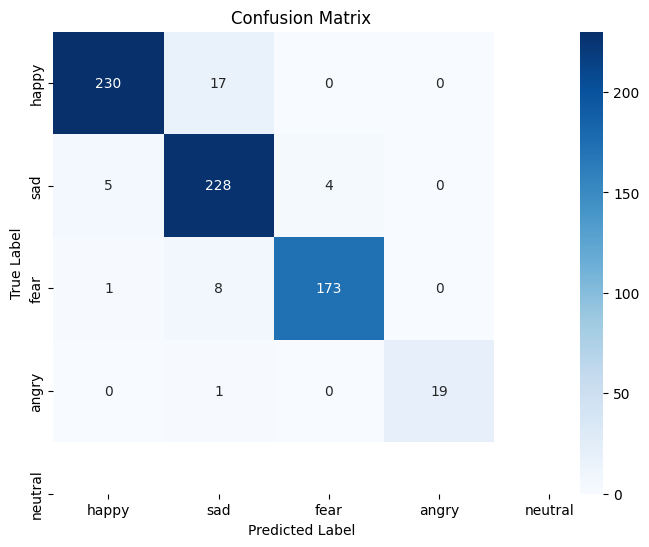

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Step 6: Predict Emotion for a New Audio File and Convert to Human Phrases
def emotion_to_phrase(emotion):
    phrases = {
        "angry": "I'm really frustrated right now!",
        "fear": "I'm scared and nervous!",
        "happy": "I'm so excited and joyful!",
        "neutral": "I'm feeling okay, nothing special.",
        "sad": "I'm feeling down and lonely...",
    }
    return phrases.get(emotion, "I can't describe this emotion.")

def predict_emotion(audio_file):
    features = extract_features(audio_file)
    features = np.expand_dims(features, axis=0)  # Reshape for model input
    prediction = model.predict(features)
    predicted_label = cluster_to_emotion[np.argmax(prediction)]
    human_phrase = emotion_to_phrase(predicted_label)
    print(f"Predicted Emotion for {audio_file}: {predicted_label}")
    print(f"Human-like response: {human_phrase}")

# Predict for a given audio file
predict_emotion("cat_1.wav")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Emotion for cat_1.wav: happy
Human-like response: I'm so excited and joyful!
